# Example 1: TICA Lightcurves of WASP-62 (Sector 31)

In this notebook, we will use a simple aperture photometry to extract the lightcurve of WASP-31 as observed by TESS in Sector 31.

The star was observed by TESS on its Camera 4, CCD 1 in Sector 31 (useful in finding reference star). The TICA data was downloaded from [TESSCut](https://mast.stsci.edu/tesscut/).

In the notebook, we will follow the following steps:

1. Background Correction
2. Simple aperture photometry

And we will see if we are able to retrieve something similar to that found by SPOC pipeline.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy.table import Table

In [2]:
# Loading the PDCSAP Data
tim_pdc, fl_pdc, fle_pdc = np.loadtxt('Data/WASP-62_PDCSAP.dat', usecols=(0,1,2), unpack=True)

# TICA data
hdul = fits.open('Data/tica-s0031-4-1_wasp62_10x15_astrocut.fits')
tab1 = Table.read(hdul[1])

Let's first plot how PDC-SAP data looks like,

Text(0.5, 1.0, 'PDC-SAP lightcurve of WASP-62 (Sector 31)')

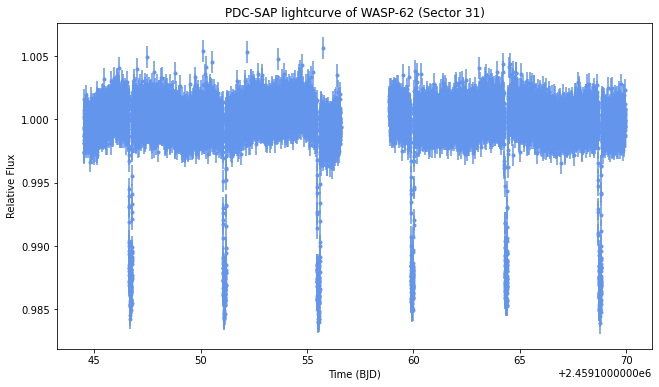

In [3]:
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim_pdc, fl_pdc, yerr=fle_pdc, fmt='.', c='cornflowerblue')
plt.xlabel('Time (BJD)')
plt.ylabel('Relative Flux')
plt.title('PDC-SAP lightcurve of WASP-62 (Sector 31)')

Now, digging into TICA,

In [4]:
tab1.colnames

['TIME',
 'CADENCENO',
 'RAW_CNTS',
 'FLUX',
 'FLUX_ERR',
 'FLUX_BKG',
 'FLUX_BKG_ERR',
 'QUALITY',
 'POS_CORR1',
 'POS_CORR2',
 'FFI_FILE']

Okay, so, it has times and flux. But I believe the `FLUX_ERR` is empty -- they do not perform error propagation as this is supposed to be a "quick-look" data. The same is true for `FLUX_BKG`, `FLUX_BKG_ERR` and `QUALITY`. We show this below:

In [5]:
print(np.where(tab1['FLUX_ERR'] != 0.))
print(np.where(tab1['FLUX_BKG'] != 0.))
print(np.where(tab1['FLUX_BKG_ERR'] != 0.))
print(np.where(tab1['QUALITY'] != 0.))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)


See?! All of those arrays are populated with zeros. Let's see, if `POS_CORR` and `POS_CORR` has something useful in it or not.

In [6]:
print(np.where(tab1['POS_CORR1'] != 0.))
print(np.where(tab1['POS_CORR2'] != 0.))

(array([], dtype=int64),)
(array([], dtype=int64),)


Well, even those are filled with zeros. Nevermind, we will determine the positions from the center of mass of the aperture later on.

The good news here is that the `TIME` and `FLUX` fields are not all zeros -- they do have some useful data. The `TIME` column is simply times of each exposure. However, `FLUX` array is somewhat similar to a more popular TESS TPF time-stams, i.e., they are detector (cut) image at given time. And the full array is time-series.

In [8]:
tims, flxs = tab1['TIME'], tab1['FLUX']
print(tims.shape)
print(flxs.shape)

(3459,)
(3459, 15, 10)


Okay, so the flux array is 2d time-series of detector image. Let's see how one of the arbitrary time-stamp looks like.

Text(0.5, 1.0, 'Timestamp at BJD = 2165.1009')

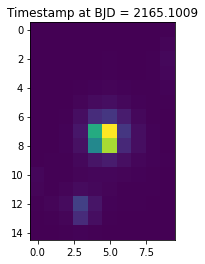

In [25]:
nint = np.random.randint(0,3460)
im = plt.imshow(flxs[nint,:,:])
plt.title('Timestamp at BJD = {:.4f}'.format(tims[nint]))

Let's see the median image,

Text(0.5, 1.0, 'Median Image')

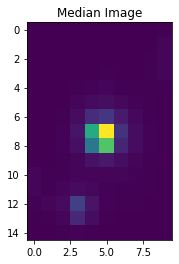

In [26]:
med_img = np.median(flxs, axis=0)

plt.imshow(med_img)
plt.title('Median Image')

Not so different! We will use this image to generate the aperture. We will do so by simply selecting ~10 brightest pixels from this image, but we need to be careful in not selecting the pixels on the bottom-right of the image.